# ARIMA Model for Google Stock Price Data
### Claire Kintzley - DSCI 575

## Data Pre-Processing

In [105]:
# installs
# %pip install pandas 
# %pip install matplotlib
# %pip install pmdarima

In [106]:
# imports
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [107]:
# Load data from csv
data = pd.read_csv('GOOG.csv')
data['Date'] = pd.to_datetime(data['Date'])
print(data.head())
# Only interested in opening price data
GoogOpen = data[['Date', 'Open']]
GoogOpen.set_index('Date', inplace=True)
print(GoogOpen.head())

        Date      Open      High       Low     Close  Adj Close     Volume
0 2004-08-19  2.490664  2.591785  2.390042  2.499133   2.499133  897427216
1 2004-08-20  2.515820  2.716817  2.503118  2.697639   2.697639  458857488
2 2004-08-23  2.758411  2.826406  2.716070  2.724787   2.724787  366857939
3 2004-08-24  2.770615  2.779581  2.579581  2.611960   2.611960  306396159
4 2004-08-25  2.614201  2.689918  2.587302  2.640104   2.640104  184645512
                Open
Date                
2004-08-19  2.490664
2004-08-20  2.515820
2004-08-23  2.758411
2004-08-24  2.770615
2004-08-25  2.614201


### Data Visualization

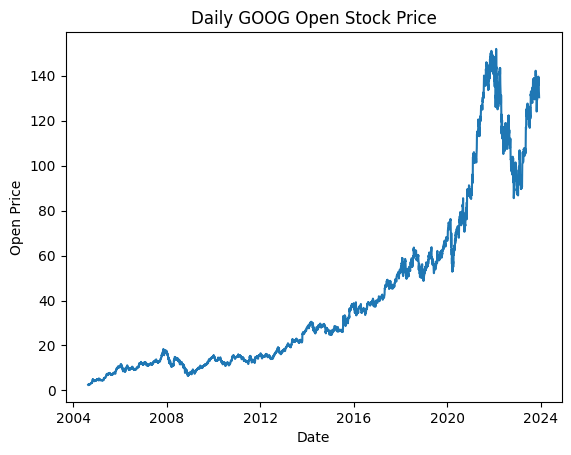

In [108]:
# Plot the time series
plt.plot(GoogOpen['Open'])
plt.title('Daily GOOG Open Stock Price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.show()

Based on an initial look at the GOOG Open price data, out time series does not appear to be stationary. I will perform an Augmented Dickey-Fuller Test for Stationarity and then perform differencing if necessary.  

### Augmented Dickey-Fuller (ADF) Test for Stationarity

- **Null Hypothesis:** The time series  has a unit root (i.e., it is non-stationary) \n
- **Alternate Hypothesis:** The time series does not have a unit root (i.e., it is stationary)

In [109]:
from statsmodels.tsa.stattools import adfuller

open = GoogOpen['Open']

adf_test = adfuller(open)
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: 0.856510
p-value: 0.992496


Since the p-value of 0.992496 is extremely high, we have no evidence to reject the null hypothesis and conclude that the time series is non-stationary. We will now perform some data processing to achieve an stationary series.

### Eliminate Trend and Seasonality

We can decompose the series into trend and seasonality to better understand the behavior of the series.

<Figure size 640x480 with 0 Axes>

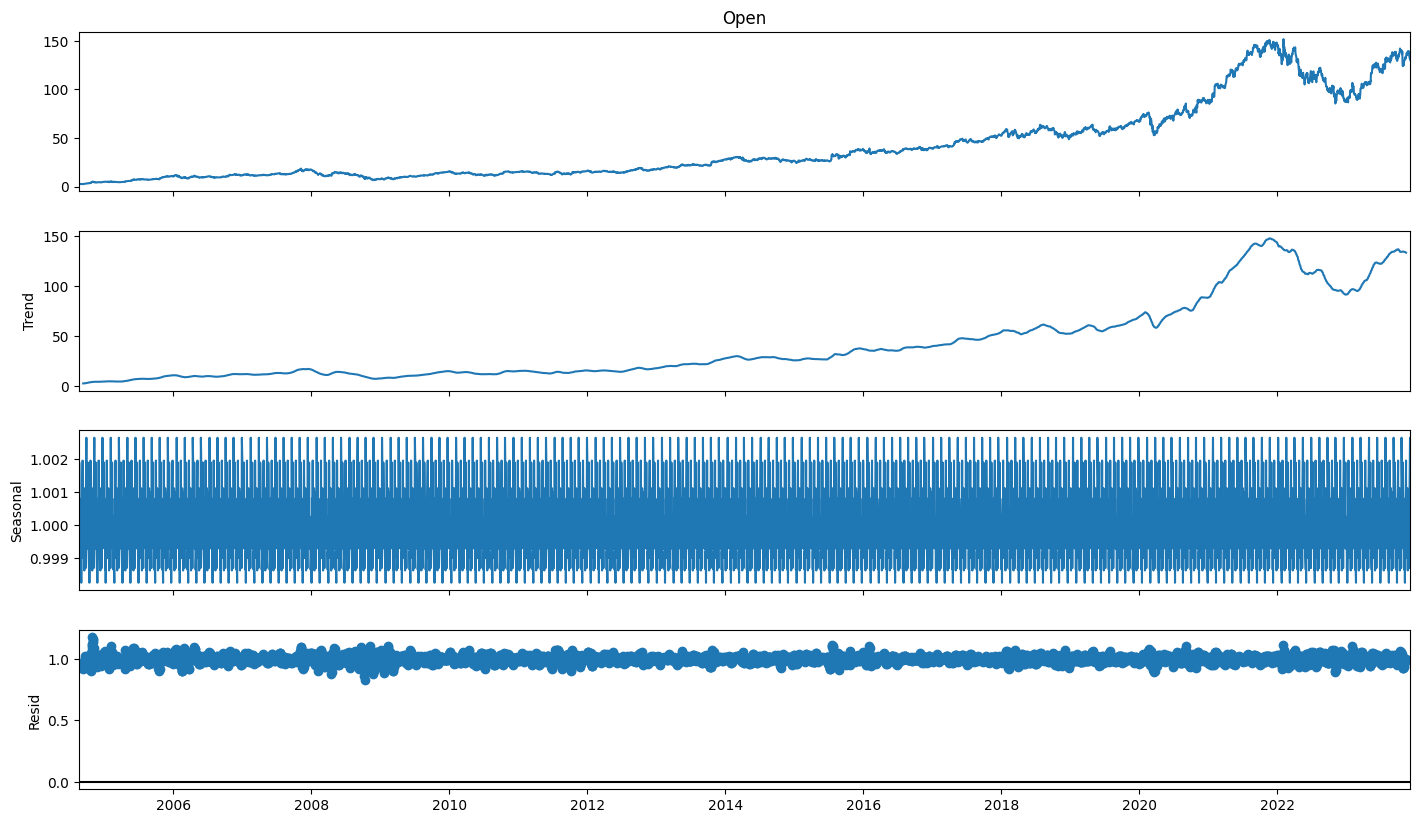

In [110]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

result = seasonal_decompose(open, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

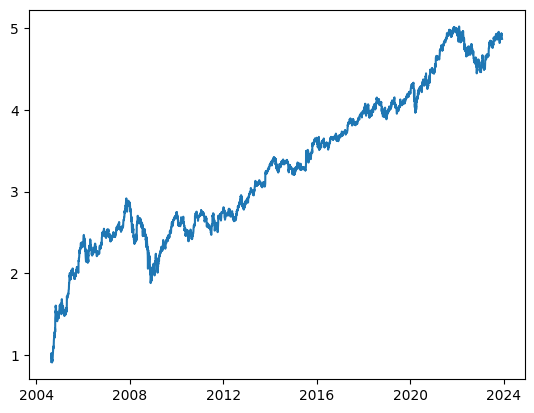

In [111]:
# Attempt to eliminate rend by taking log
log_open = np.log(GoogOpen['Open'])

plt.plot(log_open)

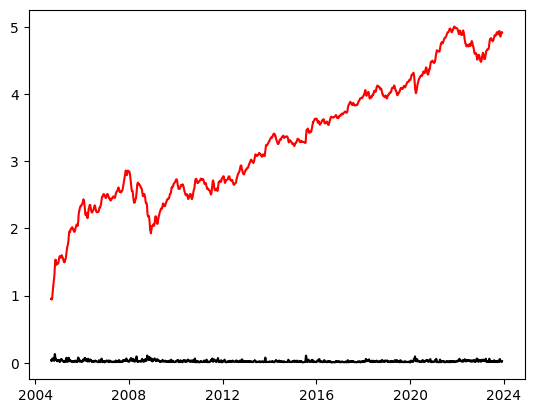

In [112]:
# Take a look at 12-month moving average
moving_avg = log_open.rolling(12).mean()
std_dev = log_open.rolling(12).std()

plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")

## Model Fitting

### Training/Testing Split

In [113]:
# Split data for training and testing model
split_index = int(len(log_open) * 0.9)
train_open = GoogOpen['Open'][:split_index]
test_open = GoogOpen['Open'][split_index:]

# Same split for log
train_log_open = log_open[:split_index]
test_log_open = log_open[split_index:]

### Differencing

Taking a look at the plot and ADF Test for first order differencing, we appear to have strong evidence for stationarity after taking a first-order difference. We will use a model with d=1.

ADF Statistic (d=0): -1.483568
p-value (d=0): 0.541624
ADF Statistic (d=1): -18.354052
p-value (d=1): 0.000000


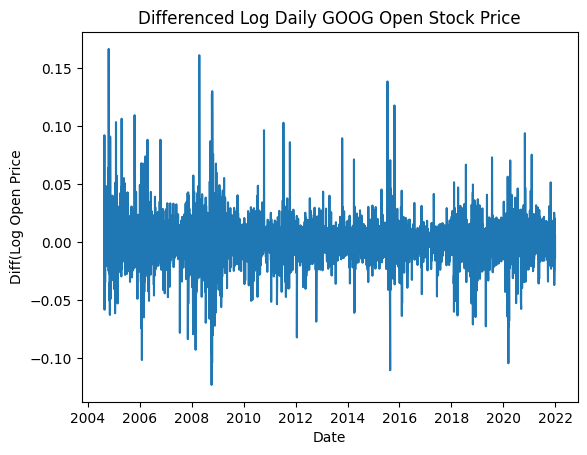

In [114]:
# Taking first difference
diff_train_log_open = train_log_open.diff().dropna()

# Look at ADF test
adf_test_diff0 = adfuller(train_log_open)
print('ADF Statistic (d=0): %f' % adf_test_diff0[0])
print('p-value (d=0): %f' % adf_test_diff0[1])

adf_test_diff1 = adfuller(diff_train_log_open)
print('ADF Statistic (d=1): %f' % adf_test_diff1[0])
print('p-value (d=1): %f' % adf_test_diff1[1])

plt.plot(diff_train_log_open)
plt.title('Differenced Log Daily GOOG Open Stock Price')
plt.xlabel('Date')
plt.ylabel('Diff(Log Open Price')
plt.show()

### Fitting Parameters

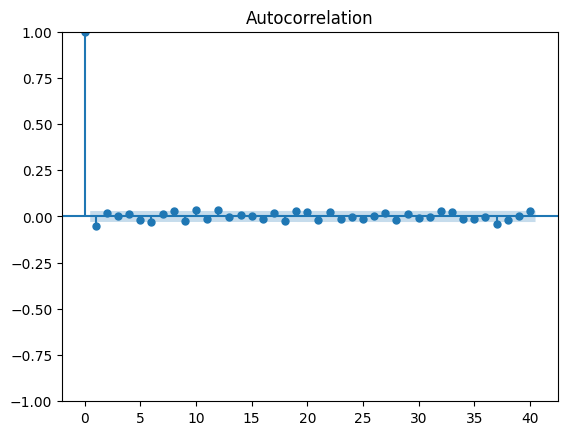

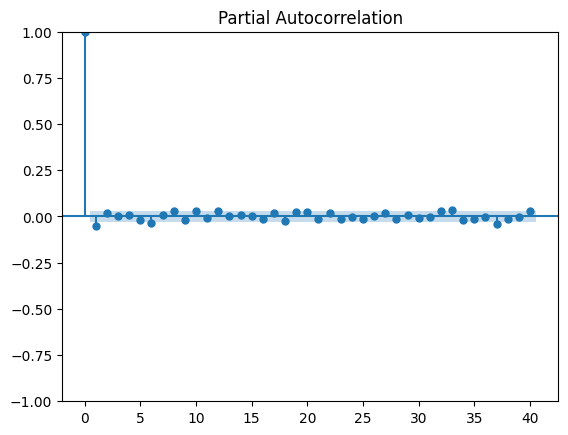

In [115]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(diff_train_log_open, lags=40)
plot_pacf(diff_train_log_open, lags=40)
plt.show()

We will use Auto ARIMA to find the optimal parametes assuming a differencing of order 1.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22210.303, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22219.149, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22218.710, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22201.866, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22218.708, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22218.639, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-22216.730, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-22209.646, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.590 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4372
Model:               SARIMAX(1, 1, 0)   Log Likelihood               11112.575
Date:                Sun, 24 Nov 2024   AIC                         -22219.149
Time:               

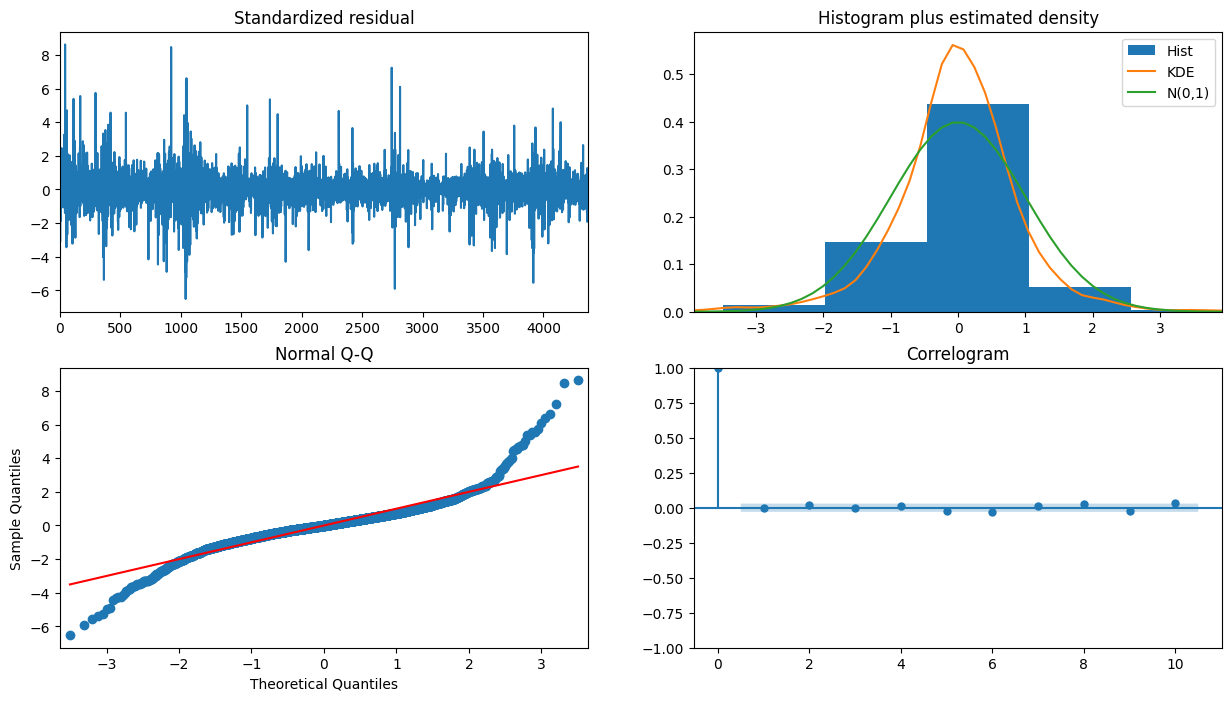

In [116]:
from pmdarima.arima import auto_arima

model_auto = auto_arima(train_log_open, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())
model_auto.plot_diagnostics(figsize=(15,8))
plt.show()

In [117]:
# Build Model
model = ARIMA(train_log_open, order=(1,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 4372
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11106.823
Date:                Sun, 24 Nov 2024   AIC                         -22209.646
Time:                        13:19:40   BIC                         -22196.881
Sample:                             0   HQIC                        -22205.142
                               - 4372                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0473      0.010     -4.953      0.000      -0.066      -0.029
sigma2         0.0004    3.4e-06    106.973      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Forecasting

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


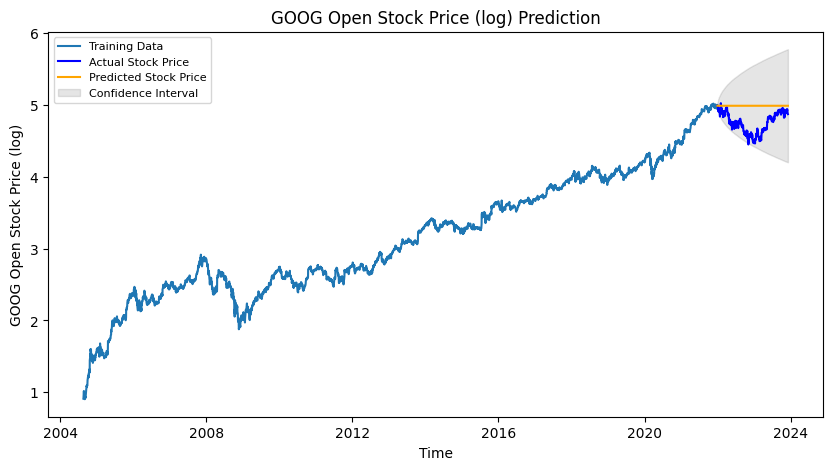

In [118]:
# Length of the testing data
n_test = len(test_log_open)

# Forecast for the length of the test set
forecast_result = fitted.get_forecast(steps=n_test)

# Extract forecasted values and confidence intervals
fc = forecast_result.predicted_mean
conf = forecast_result.conf_int(alpha=0.05)

# Align forecasted values and confidence intervals with test_log_open index
fc_series = pd.Series(fc.values, index=test_log_open.index)  # Align forecasted values
lower_series = pd.Series(conf.iloc[:, 0].values, index=test_log_open.index)  # Lower bound
upper_series = pd.Series(conf.iloc[:, 1].values, index=test_log_open.index)  # Upper bound

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_log_open, label='Training Data')
plt.plot(test_log_open, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=0.1, label='Confidence Interval')
plt.title('GOOG Open Stock Price (log) Prediction')
plt.xlabel('Time')
plt.ylabel('GOOG Open Stock Price (log)')
plt.legend(loc='upper left', fontsize=8)
plt.show()


### Tranforming Out of Log Scale

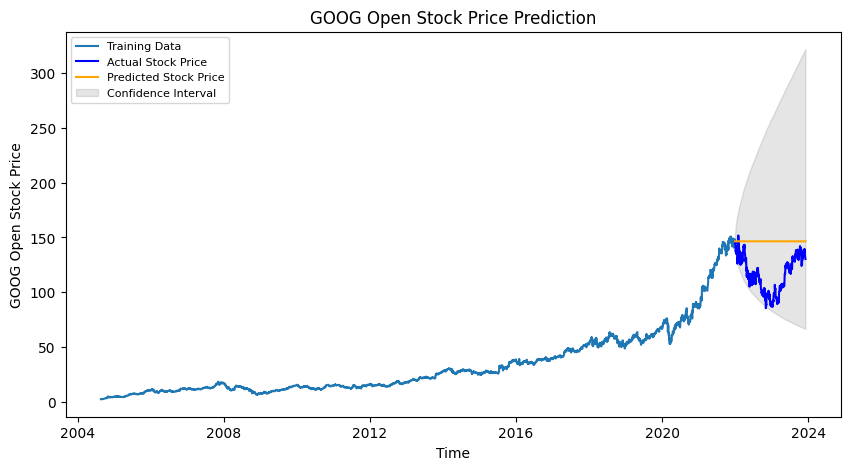

In [119]:
# Invert log transformation to return to original scale (prices)
fc_price = np.exp(fc)  # Apply exp to forecasted values to get them back to the original price scale
lower_price = np.exp(conf.iloc[:, 0])  # Apply exp to lower bound of CI
upper_price = np.exp(conf.iloc[:, 1])  # Apply exp to upper bound of CI

# Align forecasted values and confidence intervals with test_log_open index
fc_price_series = pd.Series(fc_price.values, index=test_log_open.index)  # Align forecasted values
lower_price_series = pd.Series(lower_price.values, index=test_log_open.index)  # Lower bound
upper_price_series = pd.Series(upper_price.values, index=test_log_open.index)  # Upper bound

# Plotting
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_open, label='Training Data')
plt.plot(test_open, color='blue', label='Actual Stock Price')
plt.plot(fc_price_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_price_series.index, lower_price_series, upper_price_series, 
                 color='k', alpha=0.1, label='Confidence Interval')
plt.title('GOOG Open Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOG Open Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Evaluation

### MSE, MAE, RMSE, MAPE for 10% Testing Data

Evaluating model on original scale so we can compare it to RNN models.

In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# report performance
mse = mean_squared_error(test_open, fc_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_open, fc_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_open, fc_price))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc_price_series - test_open)/np.abs(test_open))
print('MAPE: '+str(mape))

MSE: 1152.9383276182211
MAE: 29.804081442798616
RMSE: 33.95494555463491
MAPE: 0.2809910168379773


### Single Day (Next-Day) Prediction
Take a look at the next prediction 

In [145]:
# Day of prediction - first day of testing data
GoogOpen.index[split_index]

Timestamp('2021-12-30 00:00:00')

In [160]:
next_day_pred = fc_price_series.iloc[0]
next_day_true = GoogOpen.iloc[split_index]['Open']  # Get the true value for the next day after the split

# Calculate prediction error
pred_error = abs(next_day_true - next_day_pred)

# Print results
print("True value for 12/30/21:", next_day_true)
print("Predicted value for 12/30/21:", next_day_pred)
print("Prediction error (absolute) for 12/30/21:", pred_error)

True value for 12/30/21: 146.449997
Predicted value for 12/30/21: 146.52089307956717
Prediction error (absolute) for 12/30/21: 0.07089607956717714
